In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
import xarray as xr
from cycle_detection import detect_respiration_cycles
from deform_tools import deform_to_cycle_template
from respiration_features import get_all_respiration_features
import tqdm
from params import * 
import ghibtools as gt
%matplotlib inline

## LOAD 

In [3]:
stretch = False

In [4]:
input_file = f'../dataarray/da_staged_{patient}.nc'

In [5]:
da = xr.load_dataarray(input_file)#.dropna(dim='time').sel(stage = stage_to_study)

In [6]:
da = da.loc[stage_to_study,:,:].dropna(dim='time')
da

<xarray.DataArray (chan: 11, time: 2342400)>
array([[  95.14649446,   95.97592585,   94.95048881, ...,  217.71074974,
         217.34368052,  216.66289558],
       [  51.48607885,   50.68014007,   51.52982934, ...,  -46.78849694,
         -48.03497209,  -48.73148118],
       [ -38.14147539,  -38.64330246,  -38.958295  , ...,  -33.11887216,
         -34.66144563,  -35.92993815],
       ...,
       [  27.58601872,   27.91584779,   28.28031039, ...,   29.64699907,
          29.71136266,   29.61590715],
       [ 105.6410792 ,  102.21658733,  103.34747745, ...,  -54.73219028,
         -66.95900323,  -61.64147928],
       [ -88.13080057, -100.31899212, -105.01909417, ...,  -74.35398718,
         -71.96556301,  -65.7377437 ]])
Coordinates:
  * time     (time) float64 0.0 0.003906 0.007812 ... 9.15e+03 9.15e+03 9.15e+03
  * chan     (chan) object 'Fp2-C4' 'C4-T4' 'T4-O2' ... 'DEBIT' 'THERM' 'ECG'
    stage    <U2 'N2'

## PARAMS

In [7]:
chans = list(da.coords['chan'].values)

In [8]:
save = True

In [9]:
save_presentation = False

## TOOLS

In [10]:
def rsp_cycle_detection(resp_sig, method='bycycle', srate=srate):
    if method == 'sam':
        cycles = detect_respiration_cycles(resp_sig, sampling_rate=srate, t_start = 0., output = 'index',

                                        # preprocessing
                                        inspiration_sign = rsp_detect_sign[patient],
                                        high_pass_filter = None,
                                        constrain_frequency = None,
                                        median_windows_filter = None,

                                        # baseline
                                        baseline_with_average = True,
                                        manual_baseline = 0.,

                                        # clean
                                        eliminate_time_shortest_ratio = 2,
                                        eliminate_amplitude_shortest_ratio = 10,
                                        eliminate_mode = 'OR', # 'AND'

                                        )
    elif method == 'bycycle':
        from bycycle.features import compute_features
        df_features = compute_features(sig=resp_sig, fs=srate, f_range=(0.01,2), burst_method='amp')
        cycles = df_features[['sample_zerox_rise','sample_zerox_decay']].values
        
    return cycles

In [11]:
def stretch_data(resp_features, nb_point_by_cycle, data, srate):

    # params
    cycle_times = resp_features[['inspi_time', 'expi_time']].values
    mean_cycle_duration = np.mean(resp_features[['insp_duration', 'exp_duration']].values, axis=0)
    mean_inspi_ratio = mean_cycle_duration[0]/mean_cycle_duration.sum()
    times = np.arange(0,np.size(data))/srate

    clipped_times, times_to_cycles, cycles, cycle_points, data_stretch_linear = deform_to_cycle_template(
            data, times, cycle_times, nb_point_by_cycle=nb_point_by_cycle, inspi_ratio=0.4)

    nb_cycle = data_stretch_linear.shape[0]//nb_point_by_cycle
    phase = np.arange(nb_point_by_cycle)/nb_point_by_cycle
    data_stretch = data_stretch_linear.reshape(int(nb_cycle), int(nb_point_by_cycle))

    return data_stretch

In [12]:
def plot_cycle_points(resp, cycles, tmins = np.linspace(0,500,8) , srate=srate, save_presentation=save_presentation, rsp_chan=rsp_chan[patient]):
    # resp = gt.norm(resp)
    fig, axs = plt.subplots(nrows = 2, ncols = 4, figsize = (25,15))
    
    for i, tmin in enumerate(tmins):
        if i < 4:
            row = 0
            col = i
        else:
            row = 1
            col = i - 4
        ax = axs[row, col]
        
        ax.plot(resp)
        ax.plot(cycles[:,0], resp[cycles[:,0]], 'o', color = 'b')
        ax.plot(cycles[:,1], resp[cycles[:,1]], 'o', color = 'r')
        ax.set_xlim(tmin*srate, (tmin + 20)*srate)
        ax.set_ylim(np.mean(resp) - np.std(resp)*2.5,np.mean(resp) + np.std(resp)*2.5)
        ax.set_title(f'Resp signal from {rsp_chan} : cycle detection')
    if save_presentation:
        plt.savefig('../presentation/rsp_cycle_detection')
    plt.show()

## DATA SEL

In [13]:
resp_sig = da.loc[rsp_chan[patient],:].values
da_eeg = da.loc[eeg_chans,:]

## CYCLE DETECTION

In [14]:
cycles = rsp_cycle_detection(resp_sig, method='sam')

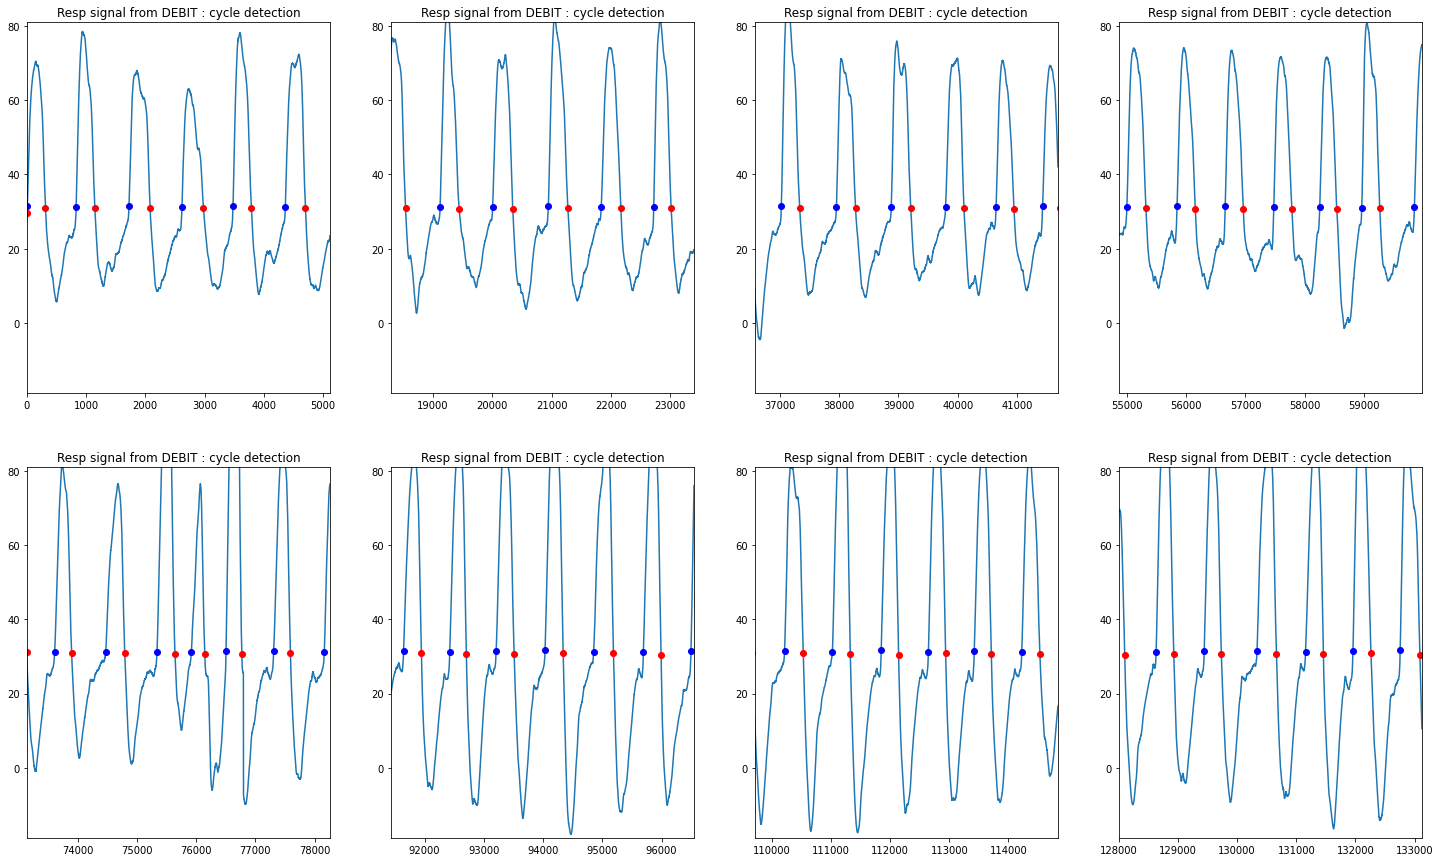

In [15]:
plot_cycle_points(resp=resp_sig, cycles=cycles)

## RESP FEATURES FROM CYCLES & RESP

In [16]:
def get_clean_rsp_features(resp_sig, cycles, srate=srate, duration_min=1.5, duration_max = 15, inspi_min=0.5, inspi_max=10):
    resp_features = get_all_respiration_features(resp_sig=resp_sig, sampling_rate=srate, cycles=cycles, t_start = 0.)
    resp_features.insert(0 , 'patient' , patient)
    initial_n_cycles = resp_features.shape[0]
    
    clean_cycles = []
    for i in range(resp_features.shape[0]):
        cycle = resp_features.loc[i ,:]
        if cycle['cycle_duration'] > duration_min and cycle['cycle_duration'] < duration_max and cycle['insp_duration'] > inspi_min and cycle['insp_duration'] < inspi_max and cycle['exp_duration'] > inspi_min and cycle['exp_duration'] < inspi_max:
            clean_cycles.append(cycle)
    
    df_return = pd.concat(clean_cycles, axis = 1).T
    
    print(f'{initial_n_cycles - df_return.shape[0]} cycles removed')
        
    return df_return

In [17]:
resp_features = get_clean_rsp_features(resp_sig, cycles)

/crnldata/cmo/Etudiants/Valentin_G/Sleep_EEG_Respi/scripts/respiration_features.py:52: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df[k] = pd.Series(index = index)
/crnldata/cmo/Etudiants/Valentin_G/Sleep_EEG_Respi/scripts/respiration_features.py:52: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df[k] = pd.Series(index = index)
/crnldata/cmo/Etudiants/Valentin_G/Sleep_EEG_Respi/scripts/respiration_features.py:52: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df[k] = pd.Series(index = index)
/crnldata/cmo/Etudiants/Valentin_G/Sleep_EEG_Respi/scripts/respiration_features.py:52: FutureWarning: The default dtype for empty Series will be 'objec

4 cycles removed


In [18]:
resp_features

,patient,cycle_num,inspi_index,expi_index,inspi_time,expi_time,cycle_duration,insp_duration,exp_duration,cycle_freq,insp_volume,exp_volume,total_amplitude,insp_amplitude,exp_amplitude
0,P10,0,9,315,0.035156,1.230469,3.21875,1.195312,2.023438,0.31068,70.149251,35.250572,101.33214,70.477427,30.854713
1,P10,1,833,1149,3.253906,4.488281,3.484375,1.234375,2.25,0.286996,76.714018,41.101259,109.483597,78.546267,30.93733
2,P10,2,1725,2081,6.738281,8.128906,3.496094,1.390625,2.105469,0.286034,80.284087,37.333431,99.03647,68.051436,30.985034
3,P10,3,2620,2982,10.234375,11.648438,3.363281,1.414062,1.949219,0.297329,73.256394,33.306419,93.975076,63.056873,30.918203
4,P10,4,3481,3791,13.597656,14.808594,3.449219,1.210938,2.238281,0.289921,75.739948,40.251144,109.223979,78.179055,31.044925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1689,P10,1689,1815572,1815900,7092.078125,7093.359375,3.144531,1.28125,1.863281,0.318012,88.749161,10.335936,125.269604,94.430902,30.838703
1690,P10,1690,1816377,1816681,7095.222656,7096.410156,3.453125,1.1875,2.265625,0.289593,84.251904,17.570151,119.336883,88.696413,30.640469
1691,P10,1691,1817261,1817586,7098.675781,7099.945312,3.367188,1.269531,2.097656,0.296984,82.172224,20.448784,120.132235,89.41743,30.714805
1692,P10,1692,1818123,1818433,7102.042969,7103.253906,3.160156,1.210938,1.949219,0.31644,87.94474,9.033463,128.657334,96.047534,32.6098


In [19]:
resp_features[['cycle_duration','insp_duration','exp_duration','cycle_freq']].mean()

cycle_duration    3.311102
insp_duration     1.221545
exp_duration      2.089557
cycle_freq        0.306617
dtype: float64

## STRETCHING NEURO DATA TO RESP CYCLES

In [20]:
if stretch:
    da_stretched = None
    for chan in eeg_chans:
        print(chan)
        data_stretch = stretch_data(resp_features=resp_features, nb_point_by_cycle=1000, data=da.loc[chan,:].values, srate=srate)
        if da_stretched is None:
            da_stretched = gt.init_da({'chan':eeg_chans, 'cycle':np.arange(0,data_stretch.shape[0],1), 'point':np.arange(0,data_stretch.shape[1],1)})
        da_stretched.loc[chan, : , :] = data_stretch

In [21]:
if save:
    resp_features.to_excel(f'../df_analyse/resp_features_{patient}.xlsx')
    if stretch:
        da_stretched.to_netcdf(f'../dataarray/da_neuro_stretched_{patient}.nc')

In [22]:
if stretch:
    da_stretched

In [23]:
if stretch:
    da_stretched.loc['Fp2-C4',:,:].plot.pcolormesh(x='point')

In [24]:
if stretch:
    for chan in eeg_chans:
        plt.figure()
        da_stretched.loc[chan,:,:].mean('cycle').plot.line(x='point')
        plt.show()